This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Advanced deep learning for computer vision

## Three essential computer vision tasks

## An image segmentation example

In [0]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [1]:
import os

input_dir = "/home/kent/college/data_sets/pets/images/"
target_dir = "/home/kent/college/data_sets/pets/annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

2022-03-14 00:15:58.892625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 00:15:58.892684: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


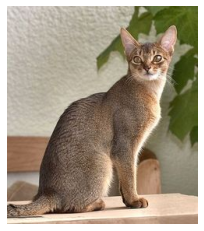

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[34]))

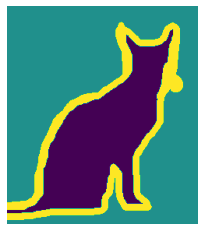

In [3]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[34], color_mode="grayscale"))
display_target(img)

In [88]:
import numpy as np
import random

img_size = (192, 192)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("float32") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="float32")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

## Image size analysis

In [89]:
train_input_imgs.shape

AttributeError: 'list' object has no attribute 'shape'

In [6]:
train_targets.shape

(6390, 192, 192, 1)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
float32
(500, 334, 3)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


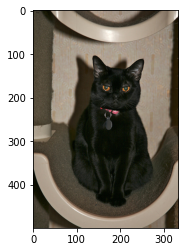

In [15]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
# load the image
img = load_img('/home/kent/college/data_sets/pets/images/Bombay_173.jpg')
print(type(img))
# convert to numpy array
img_array = img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
# convert back to image
img_pil = array_to_img(img_array)
print(type(img))
plt.imshow(img)

In [22]:
a = img_to_array(load_img('/home/kent/college/data_sets/pets/images/Bombay_173.jpg', target_size=(192,192)))

In [23]:
a_int8.shape

(192, 192, 3)

In [24]:
a[:2,:2,0]

array([[76., 70.],
       [60., 76.]], dtype=float32)

In [15]:
from skimage.color import rgb2gray

grayscale = rgb2gray(a_int8)

In [16]:
grayscale[:5,:5]

array([[67.2598  , 66.4118  , 60.411804, 73.259796, 59.7627  ],
       [59.7781  , 67.2598  , 58.7627  , 78.4098  , 67.404   ],
       [66.762695, 61.4627  , 72.33389 , 70.136795, 41.3435  ],
       [66.3339  , 65.3435  , 71.1897  , 62.762695, 62.9848  ],
       [62.2676  , 72.831   , 62.2676  , 73.411804, 63.265594]],
      dtype=float32)

In [20]:
# create the histogram
histogram, bin_edges = np.histogram(grayscale, bins=256, range=(-255, 255))

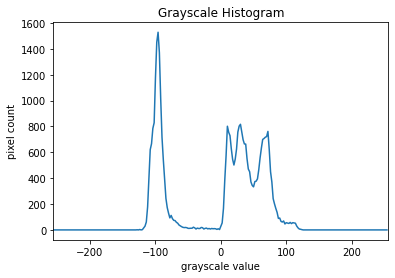

In [21]:
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([-255, 255.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

## Simple training pipeline

In [34]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [35]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [36]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val = train_input_imgs, train_targets, val_input_imgs, val_targets

In [79]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [40]:
# fit model
model.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=10,
    validation_data=(x_val, y_val),
)

2022-03-14 00:58:22.108315: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2826731520 exceeds 10% of free system memory.
2022-03-14 00:59:10.746196: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 942243840 exceeds 10% of free system memory.


Epoch 1/10
400/400 [==============================] - 1502s 4s/step - loss: -5.1899 - iou_score: 0.9642 - val_loss: -18.6751 - val_iou_score: 1.0123
Epoch 2/10
400/400 [==============================] - 1424s 4s/step - loss: -31.2302 - iou_score: 1.0401 - val_loss: -55.7256 - val_iou_score: 0.9364
Epoch 3/10
400/400 [==============================] - 1415s 4s/step - loss: -82.4793 - iou_score: 1.0440 - val_loss: -113.0317 - val_iou_score: 0.8226
Epoch 4/10
400/400 [==============================] - 1414s 4s/step - loss: -153.2556 - iou_score: 1.0454 - val_loss: -188.7719 - val_iou_score: 1.0608
Epoch 5/10
400/400 [==============================] - 1414s 4s/step - loss: -240.9256 - iou_score: 1.0497 - val_loss: -257.5658 - val_iou_score: 1.0619
Epoch 6/10
400/400 [==============================] - 1413s 4s/step - loss: -344.8497 - iou_score: 1.0514 - val_loss: -382.8088 - val_iou_score: 1.0677
Epoch 7/10
400/400 [==============================] - 1414s 4s/step - loss: -463.5269 - iou_sc

In [41]:
model.save('Unet_seg_cats_dogs.keras')

/home/kent/venv_DL/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# load an image from file
image = load_img('/home/kent/college/data_sets/scoby/IMG_20200709_192029_224.jpg', target_size=(192, 192))
# convert the image pixels to a numpy array
scoby = img_to_array(image)

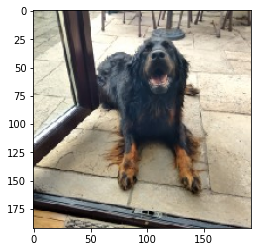

In [52]:
plt.imshow(image)

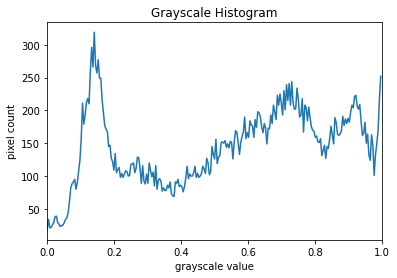

In [56]:
from skimage.color import rgb2gray

grayscale = rgb2gray(image)
histogram, bin_edges = np.histogram(grayscale, bins=256, range=(0, 1))
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [66]:
mask = train_targets[0]
mask.shape

(192, 192, 1)

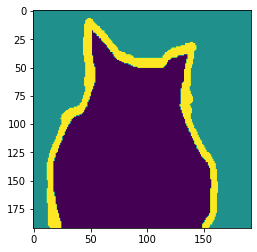

In [67]:
plt.imshow(mask)

In [80]:
mask = model.predict(np.expand_dims(scoby, 0))[0]

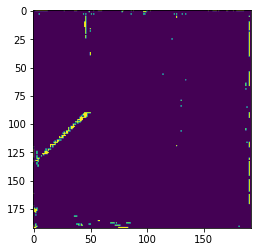

In [81]:
plt.imshow(mask)

In [84]:
mask[:4,:4,0]

array([[1., 0., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [85]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


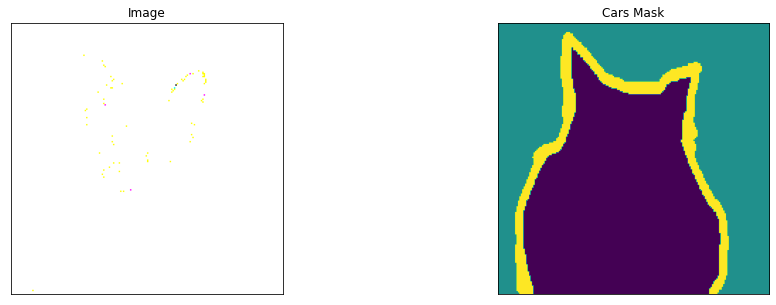

In [87]:
image, mask = train_input_imgs[0], train_targets[0]
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
#     sky_mask=mask[..., 1].squeeze(),
#     background_mask=mask[..., 2].squeeze(),
)